# LSTM MODEL IMPLEMENTATION


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv('full.csv')

In [39]:
df.head(30)

,Date,Price
0,31/01/2015,2795
1,30/01/2015,2794
2,29/01/2015,2755
3,28/01/2015,2780
4,27/01/2015,2793
5,26/01/2015,2790
6,25/01/2015,2790
7,24/01/2015,2790
8,23/01/2015,2788
9,22/01/2015,2805


__Dataset Basic Information:__

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2919 non-null   object
 1   Price   2919 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.7+ KB


In [41]:
df.describe()

,Price
count,2919.000000
mean,3701.638232
std,960.644460
min,2468.000000
25%,2917.000000
50%,3161.000000
75%,4756.500000
max,8540.000000


__All variables are stored as object.__

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [42]:
#df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [44]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [45]:
df.head()

,Date,Price
0,2015-01-01,2670.0
1,2015-01-02,2795.0
2,2015-01-03,2648.0
3,2015-01-04,2648.0
4,2015-01-05,2663.0


In [46]:
df.duplicated().sum()

0

In [47]:
df.isnull().sum().sum()

0


__Interactive Gold Price Chart:__

In [48]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.8, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [49]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

365

__Gold Price Training and Test Sets Plot:__

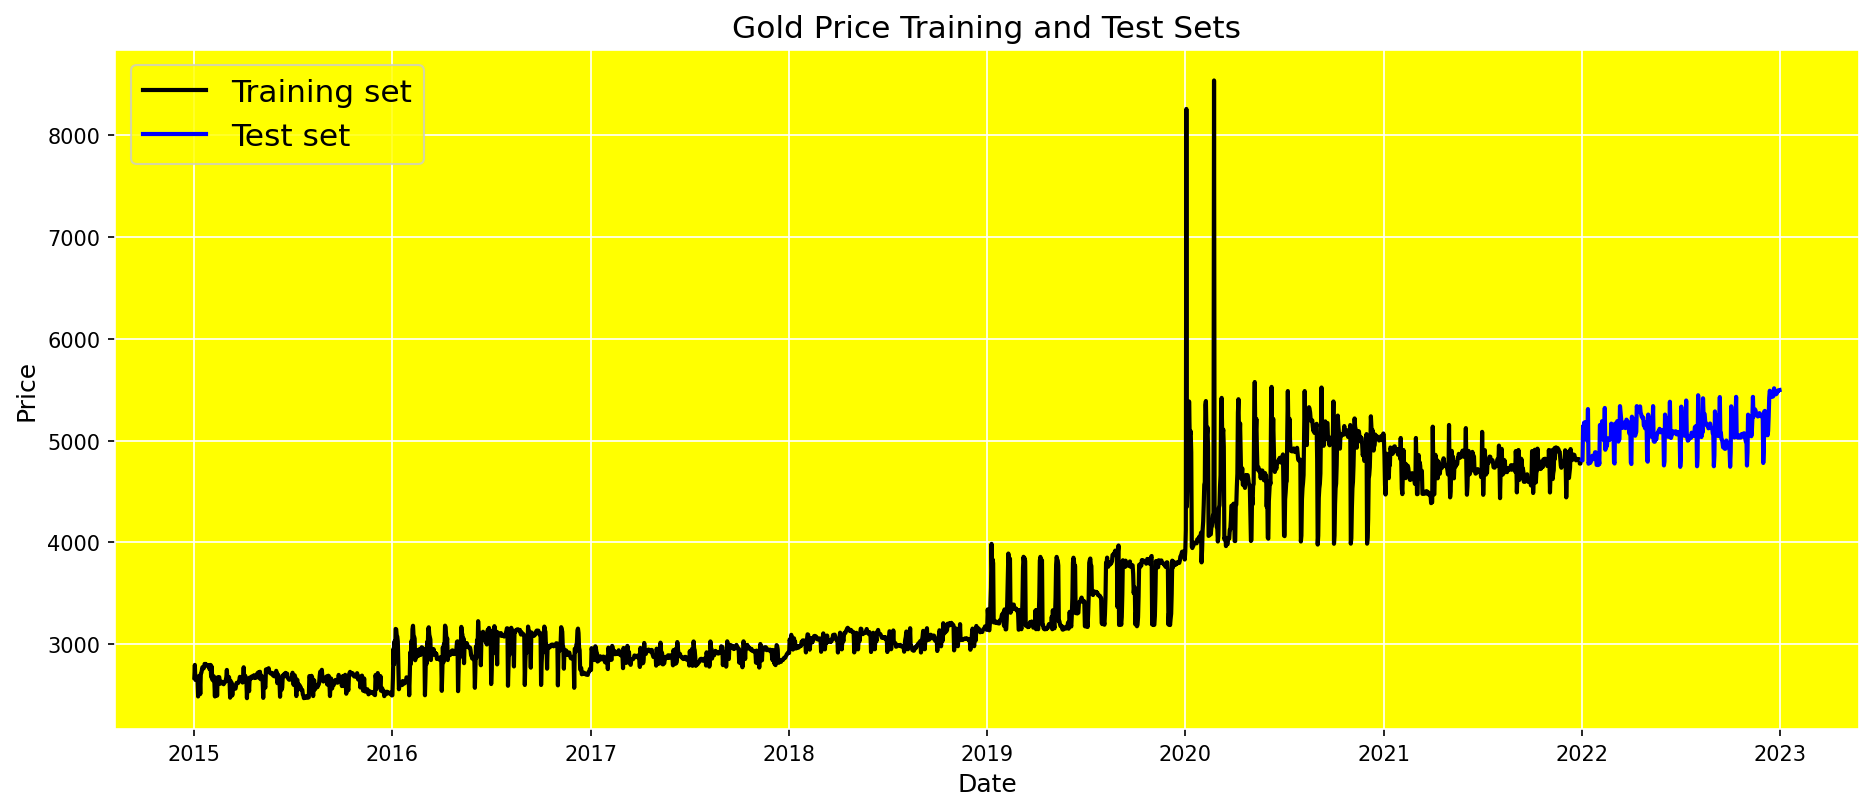

In [50]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [51]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [52]:
window_size = 60

__Training Set:__

In [53]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [54]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [55]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [56]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [57]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [58]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [59]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2494, 60, 1)
y_train Shape:  (2494, 1)
X_test Shape:   (365, 60, 1)
y_test Shape:   (365, 1)


__Model Definition:RNN__

In [60]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

__Model Training:__

In [61]:
model = define_model()
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

In [62]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

12/12 [==============================] - 2s 35ms/step


In [63]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [64]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0032076772768050432
Test MAPE: 0.1125157229638362
Test Accuracy: 0.8874842770361638


__Returning the actual and predicted Price values to their primary scale:__

In [65]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the actual prices:__

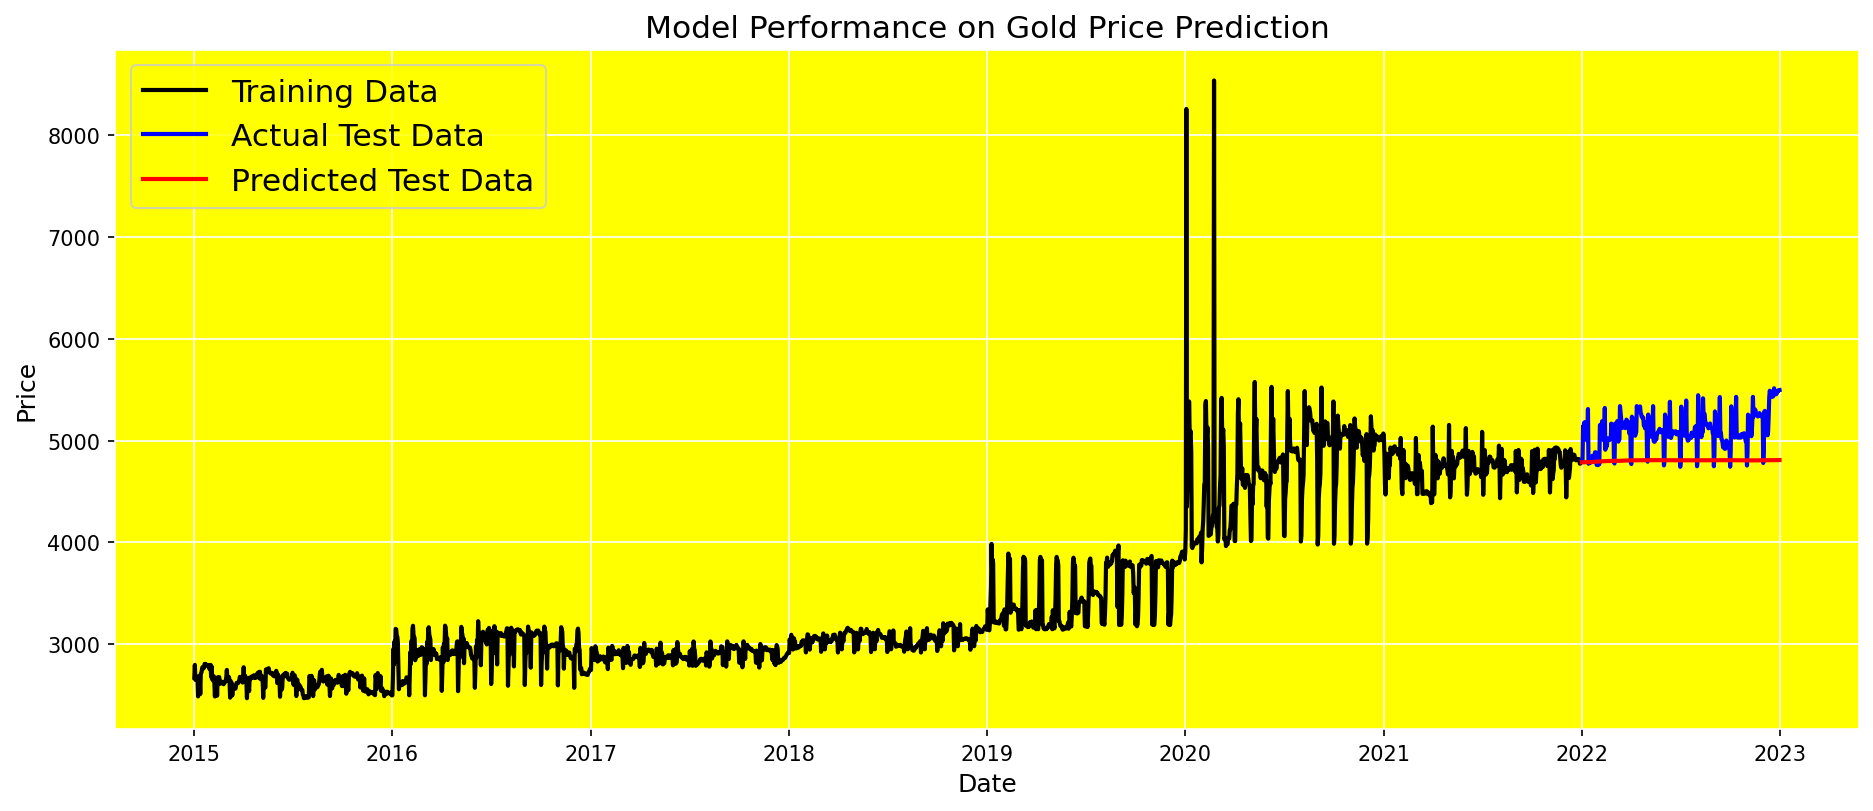

In [66]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

____
# Conclusion:
### As can be seen, the price predicted by the LSTM model follows the actual prices greatly! The value of Loss and Accuracy (1-MAPE) obtained on the test data also confirm the great performance of the model:

##  Loss: 0.004
##  Accuracy:85%-90%